In [42]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np


import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'



from pathlib import Path


from scipy.stats import trim_mean
from statsmodels import robust


import seaborn as sns
import matplotlib.pylab as plt

In [40]:
data_dir = os.getenv('HOME')+'/aiffel/datasci/csvfile'
data_path = join(data_dir, 'state.csv')


state = pd.read_csv(data_path)

print(state)

             State  Population  Murder.Rate Abbreviation
0          Alabama     4779736          5.7           AL
1           Alaska      710231          5.6           AK
2          Arizona     6392017          4.7           AZ
3         Arkansas     2915918          5.6           AR
4       California    37253956          4.4           CA
5         Colorado     5029196          2.8           CO
6      Connecticut     3574097          2.4           CT
7         Delaware      897934          5.8           DE
8          Florida    18801310          5.8           FL
9          Georgia     9687653          5.7           GA
10          Hawaii     1360301          1.8           HI
11           Idaho     1567582          2.0           ID
12        Illinois    12830632          5.3           IL
13         Indiana     6483802          5.0           IN
14            Iowa     3046355          1.9           IA
15          Kansas     2853118          3.1           KS
16        Kentucky     4339367 

In [34]:
state[['Population']].mean()



Population    6162876.3
dtype: float64

In [31]:
state['Population'].median()

4436369.5

In [32]:
df = pd.DataFrame(state)
df

,State,Population,Murder.Rate,Abbreviation
0,Alabama,4779736,5.7,AL
1,Alaska,710231,5.6,AK
2,Arizona,6392017,4.7,AZ
3,Arkansas,2915918,5.6,AR
4,California,37253956,4.4,CA
5,Colorado,5029196,2.8,CO
6,Connecticut,3574097,2.4,CT
7,Delaware,897934,5.8,DE
8,Florida,18801310,5.8,FL
9,Georgia,9687653,5.7,GA


In [38]:
from scipy.stats import trim_mean
trim_mean(df['Population'],0.1)

# 평균(mean)이 절사평균(trim)보다 크고, 절사평균은 중간값(median)보다 크다.
# 일반적으로 상하 10% 잘라서 평균을 구함

4783697.125

In [43]:
print(np.average(state['Murder.Rate'], weights=state['Population']))

4.445833981123393


In [44]:
print(wquantiles.median(state['Murder.Rate'], weights=state['Population']))

## 가중평균을 구하기 위해서는 wquantiles를 설치해야 하는데 클라우드로 설정해야 하기 때문에 넘어가자 결과 : 4.4
## 가장 기본적인 위치 추정기법은 평균!! 하지만 특이값에 민감하다.

## 중간값, 절사평균과 같은 다른 방법들이 특잇값이나 이상 데이터에 덜 민감하므로 좀 더 로버스트하다 
## -> 로버스트는 변경되지 않는 값으로 효율적인 평균값을 구하는것에 있다. -> 작은데이터일 경우 위치의 값으로 인해 결과값이 달라지기 때문에

NameError: name 'wquantiles' is not defined

## 변이추정 (산포도)

- 데이터가 중앙값을 주변으로 얼마나 퍼져있는지 말해준다
- 평균을 기준으로 편차를 구하는 방법인데 ex) {1,4,4} 평균값:3 1-3 = 2, 4-3 = 1 , 4-3 =1 이는 중앙값의 얼마나 떨어져있는지 정도를 알려준다
- 이후 우리는 떨어져있는 정도의 평균을 구할건데 평균절대편차로 구해야 함! (-가 존재하므로)  결과 : 1.33
- 수학적으로 제곱한 값이 절댓값보다 통계 모델을 다루는 데 편리
- 표준편차 와 중위절대편차 X 척도인자는 비슷한 값을 도출한가 봄

### 변이추정 _ 사분위범위

- 머신러닝에서 주로 쓰이며 백분위 기준 0.75 - 0.25 를 이용해 편차를 구하는 방법이다 .
- 계산이 빠르며 어느정도의 정확도를 보장한다. 이는 대량의 데이터에서 유용함

In [45]:
state['Population'].std() # 표준편차

6848235.347401142

In [46]:
print(state['Population'].quantile(0.75) - state['Population'].quantile(0.25))

4847308.0


In [48]:
# 팬더스 데이터 프레임은 표준편차와 분위수를 계산하는 메서드를 제공한다
print(robust.scale.mad(state['Population']))


3849876.1459979336


## 데이터 분포 탐색하기

In [51]:
## 파이썬에서는 팬더스 데이터 프레임 메서드 quantile를 제공한다
print(state['Murder.Rate'].quantile([0.05, 0.25, 0.5, 0.75, 0.95]))

# 5% 백분위수는 1.6에 불과한 반면 95% 백분위수는 6.51에 달하는 등 약간의 변동폭이 있긴 하지만, 중간값은 10만명당 4건의 살인이 있다고 알려줌

0.05    1.600
0.25    2.425
0.50    4.000
0.75    5.550
0.95    6.510
Name: Murder.Rate, dtype: float64


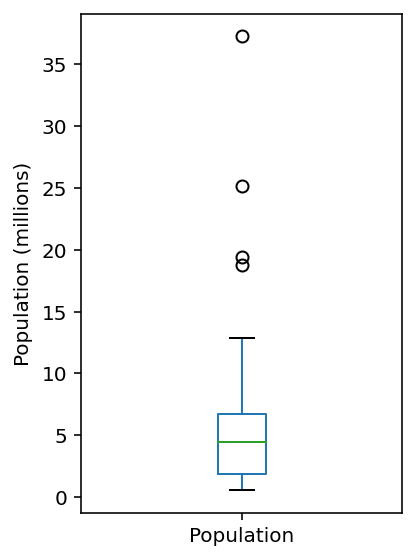

In [52]:
ax = (state['Population']/1_000_000).plot.box(figsize=(3, 4))
ax.set_ylabel('Population (millions)')

plt.tight_layout()
plt.show()

In [55]:
binnedPopulation = pd.cut(state['Population'], 10)
print(binnedPopulation.value_counts())

(526935.67, 4232659.0]      24
(4232659.0, 7901692.0]      14
(7901692.0, 11570725.0]      6
(11570725.0, 15239758.0]     2
(15239758.0, 18908791.0]     1
(18908791.0, 22577824.0]     1
(22577824.0, 26246857.0]     1
(33584923.0, 37253956.0]     1
(26246857.0, 29915890.0]     0
(29915890.0, 33584923.0]     0
Name: Population, dtype: int64


In [59]:
binnedPopulation.name = 'binnedPopulation'
df = pd.concat([state, binnedPopulation], axis=1)
df = df.sort_values(by='Population')

groups = []
for group, subset in df.groupby(by='binnedPopulation'):
    groups.append({
        'BinRange': group,
        'Count': len(subset),
        'States': ','.join(subset.Abbreviation)
    })
print(pd.DataFrame(groups))

                   BinRange  Count  \
0    (526935.67, 4232659.0]     24   
1    (4232659.0, 7901692.0]     14   
2   (7901692.0, 11570725.0]      6   
3  (11570725.0, 15239758.0]      2   
4  (15239758.0, 18908791.0]      1   
5  (18908791.0, 22577824.0]      1   
6  (22577824.0, 26246857.0]      1   
7  (26246857.0, 29915890.0]      0   
8  (29915890.0, 33584923.0]      0   
9  (33584923.0, 37253956.0]      1   

                                              States  
0  WY,VT,ND,AK,SD,DE,MT,RI,NH,ME,HI,ID,NE,WV,NM,N...  
1          KY,LA,SC,AL,CO,MN,WI,MD,MO,TN,AZ,IN,MA,WA  
2                                  VA,NJ,NC,GA,MI,OH  
3                                              PA,IL  
4                                                 FL  
5                                                 NY  
6                                                 TX  
7                                                     
8                                                     
9                              

Text(0.5, 0, 'Population (millions)')

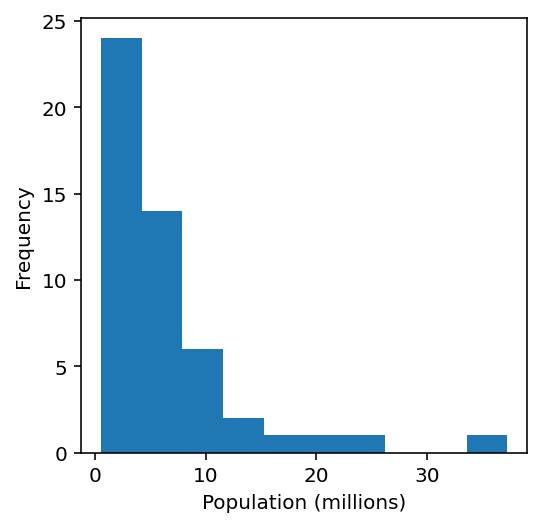

In [65]:
## 위에 나와있는 도수분포표를 시각화 하는방법이다.
# 구간의 개수를 정의하려면 키워드 인수 bin을 이용한다.
ax = (state['Population'] / 1_000_000).plot.hist(figsize=(4, 4),) # bins=range(1,12)
ax.set_xlabel('Population (millions)')

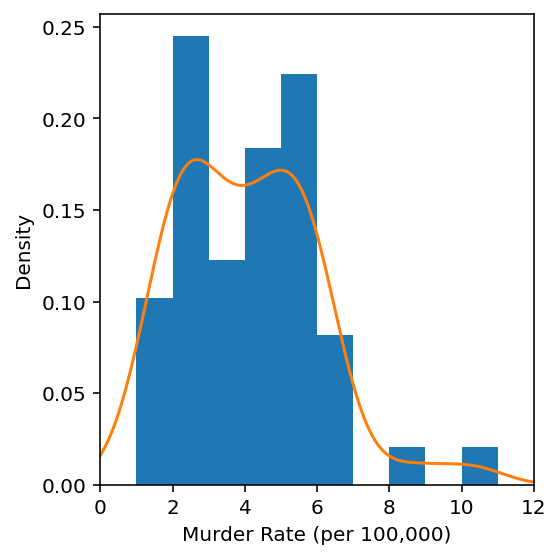

In [61]:
ax = state['Murder.Rate'].plot.hist(density=True, xlim=[0, 12], 
                                    bins=range(1,12), figsize=(4, 4))
state['Murder.Rate'].plot.density(ax=ax)
ax.set_xlabel('Murder Rate (per 100,000)')

plt.tight_layout()
plt.show()

## 이진데이터와 범주 데이터 탐색하기 (댈러스 - 포트워스 항공기 운행 지연)

In [70]:
data_path1 = join(data_dir, 'airline_stats.csv')
data_path2 = join(data_dir, 'dfw_airline.csv')



state1 = pd.read_csv(data_path1)
state2 = pd.read_csv(data_path2)
print(state2)

    Carrier      ATC   Weather  Security    Inbound
0  64263.16  84856.5  11235.42    343.15  118427.82


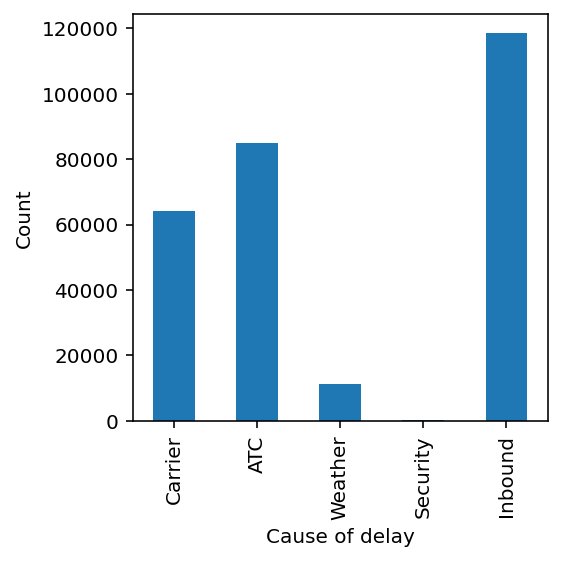

In [71]:
ax = state2.transpose().plot.bar(figsize=(4, 4), legend=False)
ax.set_xlabel('Cause of delay')
ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

### 가중평균이 기댓값이다.!!

In [86]:
data_path3 = join(data_dir, 'kc_tax.csv.gz')
data_path4 = join(data_dir, 'lc_loans.csv')
data_path5 = join(data_dir, 'sp500_data.csv.gz')
data_path6 = join(data_dir, 'sp500_sectors.csv')

state3 = pd.read_csv(data_path3)
state4 = pd.read_csv(data_path4)
state5 = pd.read_csv(data_path5,index_col=0)
state6 = pd.read_csv(data_path6)

print(state5)

                  ADS        CA      MSFT       RHT      CTSH       CSC  \
1993-01-29   0.000000  0.060124 -0.022100  0.000000  0.000000  0.018897   
1993-02-01   0.000000 -0.180389  0.027621  0.000000  0.000000  0.018889   
1993-02-02   0.000000 -0.120257  0.035900  0.000000  0.000000 -0.075573   
1993-02-03   0.000000  0.060124 -0.024857  0.000000  0.000000 -0.151128   
1993-02-04   0.000000 -0.360770 -0.060757  0.000000  0.000000  0.113350   
...               ...       ...       ...       ...       ...       ...   
2015-06-25   0.019989 -0.529999 -0.379997  0.080002  0.350003 -0.580002   
2015-06-26  -1.299988 -0.330000 -0.390004 -1.820000  0.190003  0.330002   
2015-06-29 -10.299988 -0.410000 -0.670002 -1.250000 -1.919998 -0.510002   
2015-06-30  -2.109986 -0.049999 -0.559997 -0.099999 -0.689999 -0.610001   
2015-07-01  -1.210022  0.020000 -0.009998  0.869995  0.329998 -0.190003   

                 EMC       IBM       XRX      ALTR  ...       WAT      ALXN  \
1993-01-29  0.007368

In [87]:
# Table 1-7
# Determine telecommunications symbols
telecomSymbols = state6[state6['sector'] == 'telecommunications_services']['symbol']

# Filter data for dates July 2012 through June 2015
telecom = state5.loc[state5.index >= '2012-07-01', telecomSymbols]
telecom.corr()
print(telecom)

                   T       CTL       FTR        VZ      LVLT
2012-07-02  0.422496  0.140847  0.070879  0.554180 -0.519998
2012-07-03 -0.177448  0.066280  0.070879 -0.025976 -0.049999
2012-07-05 -0.160548 -0.132563  0.055128 -0.051956 -0.180000
2012-07-06  0.342205  0.132563  0.007875  0.140106 -0.359999
2012-07-09  0.136883  0.124279 -0.023626  0.253943  0.180000
...              ...       ...       ...       ...       ...
2015-06-25  0.049342 -1.600000 -0.040000 -0.187790 -0.330002
2015-06-26 -0.256586  0.039999 -0.070000  0.029650 -0.739998
2015-06-29 -0.098685 -0.559999 -0.060000 -0.504063 -1.360000
2015-06-30 -0.503298 -0.420000 -0.070000 -0.523829  0.199997
2015-07-01 -0.019737  0.080000 -0.050000  0.355811  0.139999

[754 rows x 5 columns]


In [89]:
etfs = state5.loc[state5.index > '2012-07-01', 
                    state6[state6['sector'] == 'etf']['symbol']]
print(etfs.head())

                 XLI       QQQ       SPY       DIA       GLD    VXX       USO  \
2012-07-02 -0.376098  0.096313  0.028223 -0.242796  0.419998 -10.40  0.000000   
2012-07-03  0.376099  0.481576  0.874936  0.728405  0.490006  -3.52  0.250000   
2012-07-05  0.150440  0.096313 -0.103487  0.149420  0.239991   6.56 -0.070000   
2012-07-06 -0.141040 -0.491201  0.018819 -0.205449 -0.519989  -8.80 -0.180000   
2012-07-09  0.244465 -0.048160 -0.056445 -0.168094  0.429992  -0.48  0.459999   

                 IWM       XLE       XLY       XLU       XLB       XTL  \
2012-07-02  0.534641  0.028186  0.095759  0.098311 -0.093713  0.019076   
2012-07-03  0.926067  0.995942  0.000000 -0.044686  0.337373  0.000000   
2012-07-05 -0.171848 -0.460387  0.306431 -0.151938  0.103086  0.019072   
2012-07-06 -0.229128  0.206706  0.153214  0.080437  0.018744 -0.429213   
2012-07-09 -0.190939 -0.234892 -0.201098 -0.035751 -0.168687  0.000000   

                 XLV       XLP       XLF       XLK  
2012-07-02 -0.0

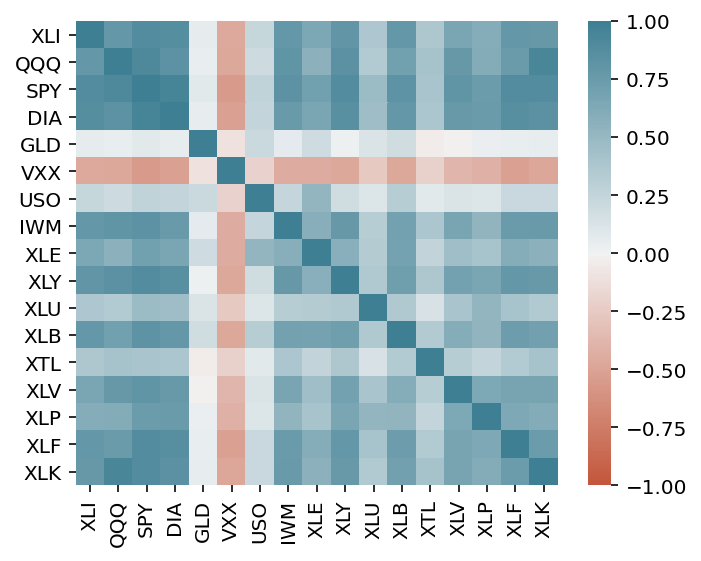

In [90]:
fig, ax = plt.subplots(figsize=(5, 4))
ax = sns.heatmap(etfs.corr(), vmin=-1, vmax=1, 
                 cmap=sns.diverging_palette(20, 220, as_cmap=True),
                 ax=ax)

plt.tight_layout()
plt.show()